In [1]:
from os.path import exists

import pandas as pd
import numpy as np

import statsmodels.api as sm

import matplotlib.pyplot as plt
import seaborn as sns

import scipy
from scipy.io.wavfile import write
from scipy.signal import butter, lfilter, freqz, find_peaks
from scipy.fftpack import fft, rfft, rfftfreq
from scipy.datasets import electrocardiogram

## Observational data of Sunspots comes from [SilSo](http://www.sidc.be/silso/dayssnplot)

 * SN_d_tot_V2.0.csv
 * SN_ms_tot_V2.0.csv

## Cleaning the data, if needed

In [2]:
if exists('../data/pickled_sunspot_data.pkl'):
    print('Using the data that has already been cleaned.')
    
else:
    print("Clean data isn't here. Cleaning and exporting.")
    
    sun = pd.read_csv('../data/SN_d_tot_V2.0.csv', sep = ';')
    sun.columns = ['Year', 'Month', 'Day', 'Fractional Date', 'SunSpot Count', "DailyStDev", "Observations", 'Indicator']
    sun['Date'] = sun['Year'].map(str)+ '-' + sun['Month'].map(str) + '-' + sun['Day'].map(str)
    
    pd.to_datetime(sun['Date'], utc=False)
    
    sun['Date'] = pd.to_datetime(sun['Date'])
        
    sun = sun[['Date', 'SunSpot Count', 'DailyStDev', 'Observations', 'Indicator', 'Fractional Date'] ]
    sun['Indicator'] = sun['Indicator'].astype(bool)
    
    sun[['Observations', 'SunSpot Count']] = sun[['Observations', 'SunSpot Count']].astype(int)
    sun.to_pickle('../data/pickled_sunspot_data.pkl')

Using the data that has already been cleaned.


In [3]:
sun = pd.read_pickle('../data/pickled_sunspot_data.pkl')
sun

,Date,SunSpot Count,DailyStDev,Observations,Indicator,Fractional Date
0,1818-01-02,-1,-1.0,0,True,1818.004
1,1818-01-03,-1,-1.0,0,True,1818.007
2,1818-01-04,-1,-1.0,0,True,1818.010
3,1818-01-05,-1,-1.0,0,True,1818.012
4,1818-01-06,-1,-1.0,0,True,1818.015
...,...,...,...,...,...,...
75631,2025-01-27,54,12.6,29,False,2025.073
75632,2025-01-28,75,11.8,19,False,2025.075
75633,2025-01-29,82,10.4,28,False,2025.078
75634,2025-01-30,106,21.0,29,False,2025.081


The negative numbers for SunSpot Count and DailyStDev indicate there was no data collected for the day. How big of a deal is that?

In [4]:
print(f"{round(sum(sun['SunSpot Count']==-1)/len(sun)*100, 3)} percent")

4.292 percent


#### Given the tradeoff of having no observational data for a day or a gap I think it's better to go with the former as we can impute numbers, if needed.

## Initial plots

#### Let's get a plot going to see if this displays well and makes sense.

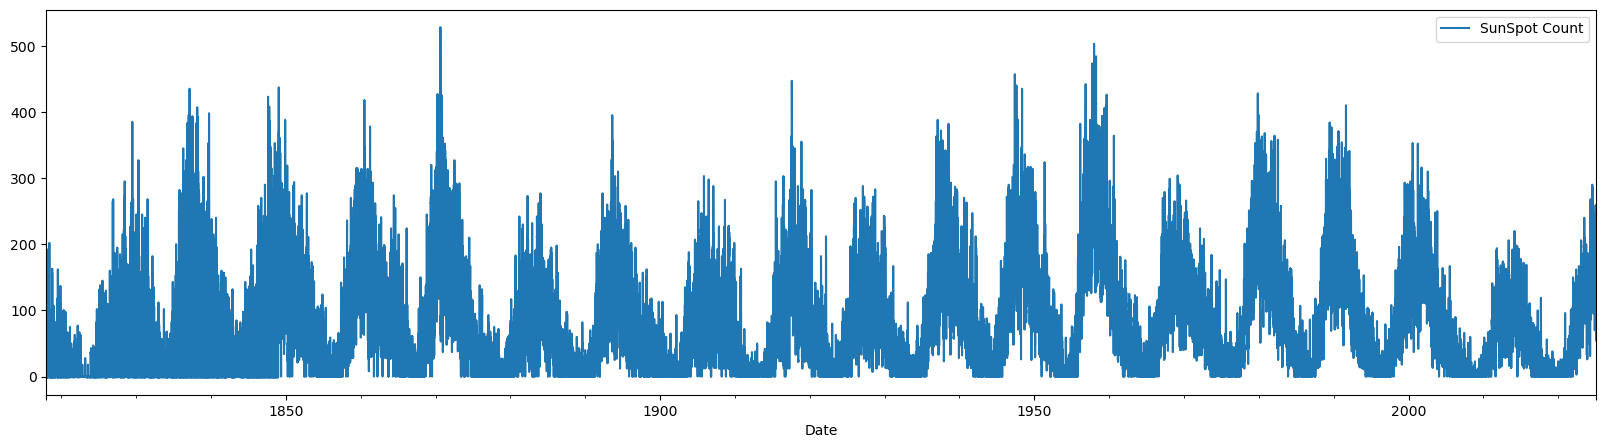

In [5]:
plt.figure(figsize = (20, 5))
ax = plt.gca()

sun.plot(kind='line', x='Date', y='SunSpot Count', ax=ax)
plt.show()

#### Hundreds of Sunspots in a day seem suspicious ... 
until you check it against the `SunSpot Count` column, `max` row. And if you use `.unique()` it seems even less concerning. I have no idea why part of the chart is displayed as white. This seems to be a quirk of Matplolib as it isn't reflected below. So, overall, I think we're good.

In [6]:
sun['SunSpot Count'].unique()

array([ -1,  65,  37,  77,  98, 105,  25,  38,  20,  17,  87, 192,  73,
        82,  28,   0,  48,  32,  47,  43,  85,  52,  80,  57,  18,  55,
        60,  62,  67,  68,  53,  92,  63,  72,  40,  50,  75, 103,  78,
       125, 132, 198, 202, 167, 100,  42,  35,  33,  90,  83,  70,  97,
        88,  22,  45,  58,  27,  23,  30, 113, 157, 163, 108, 107,  93,
       118, 117,  95, 162, 110, 137,  10,  13,   8, 102,  12, 138, 130,
       145, 127, 160, 120, 143, 150, 135, 115, 152, 142, 148, 112, 265,
       268, 227, 170, 140, 187, 123, 133, 128, 158, 155, 165, 183, 195,
       153, 185, 177, 215, 182, 223, 168, 263, 190, 233, 175, 242, 275,
       295, 273, 270, 237, 228, 210, 178, 212, 173, 193, 122, 208, 207,
       217, 200, 225, 203, 250, 385, 147, 222, 218, 245, 327, 277, 240,
       220, 253, 282, 243, 257, 252, 278, 308, 345, 232, 310, 285, 307,
       267, 262, 238, 312, 337, 292, 383, 358, 368, 260, 342, 340, 325,
       395, 320, 315, 348, 235, 357, 435, 400, 283, 293, 287, 29

## What are we doing here? What's the question and the plan?

#### At first glance, we see a cycle every 12 or so years. There's no surprise here we known this since 1843 when astronomer S.H. Schwabe was the first to describe the 11-year cycle. There's no more science in this than there is a high school or undergraduate science course.

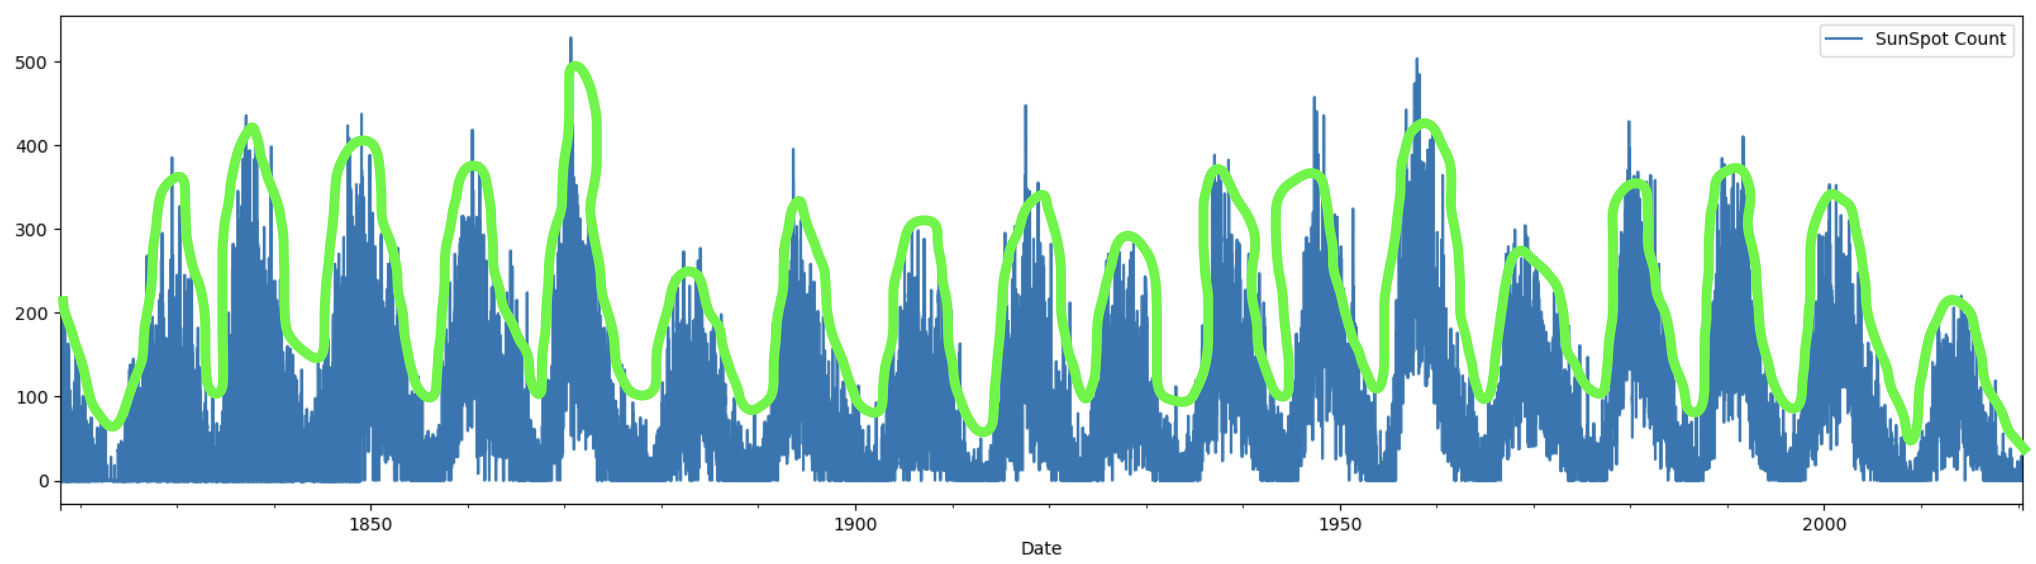

#### But that's not really my question. 
##### My question is are there other cycles or do I just perceive perhaps 2-3 other cycles one of which seems to be about 110 years or so. But is this a cycle?
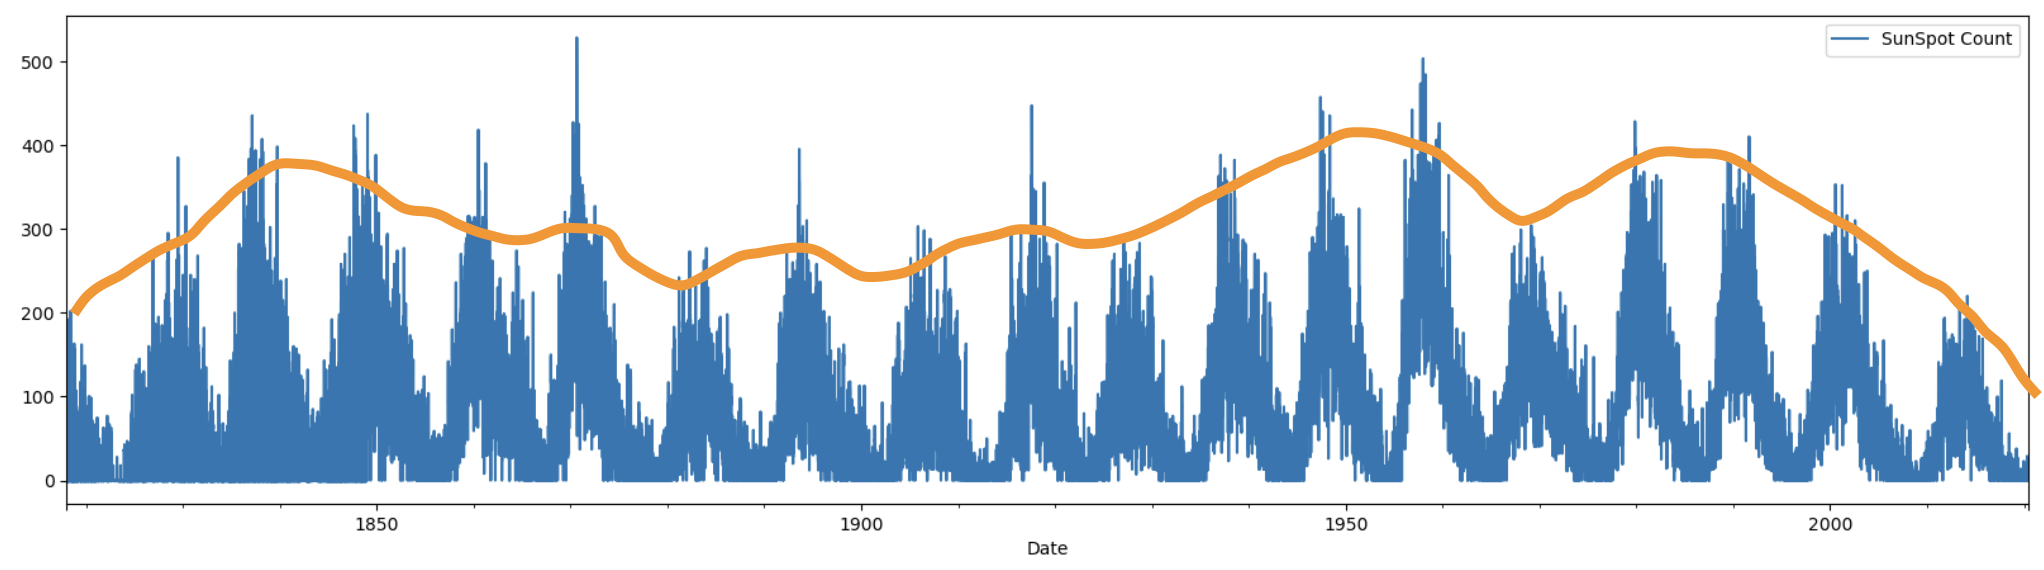

##### Or maybe this?
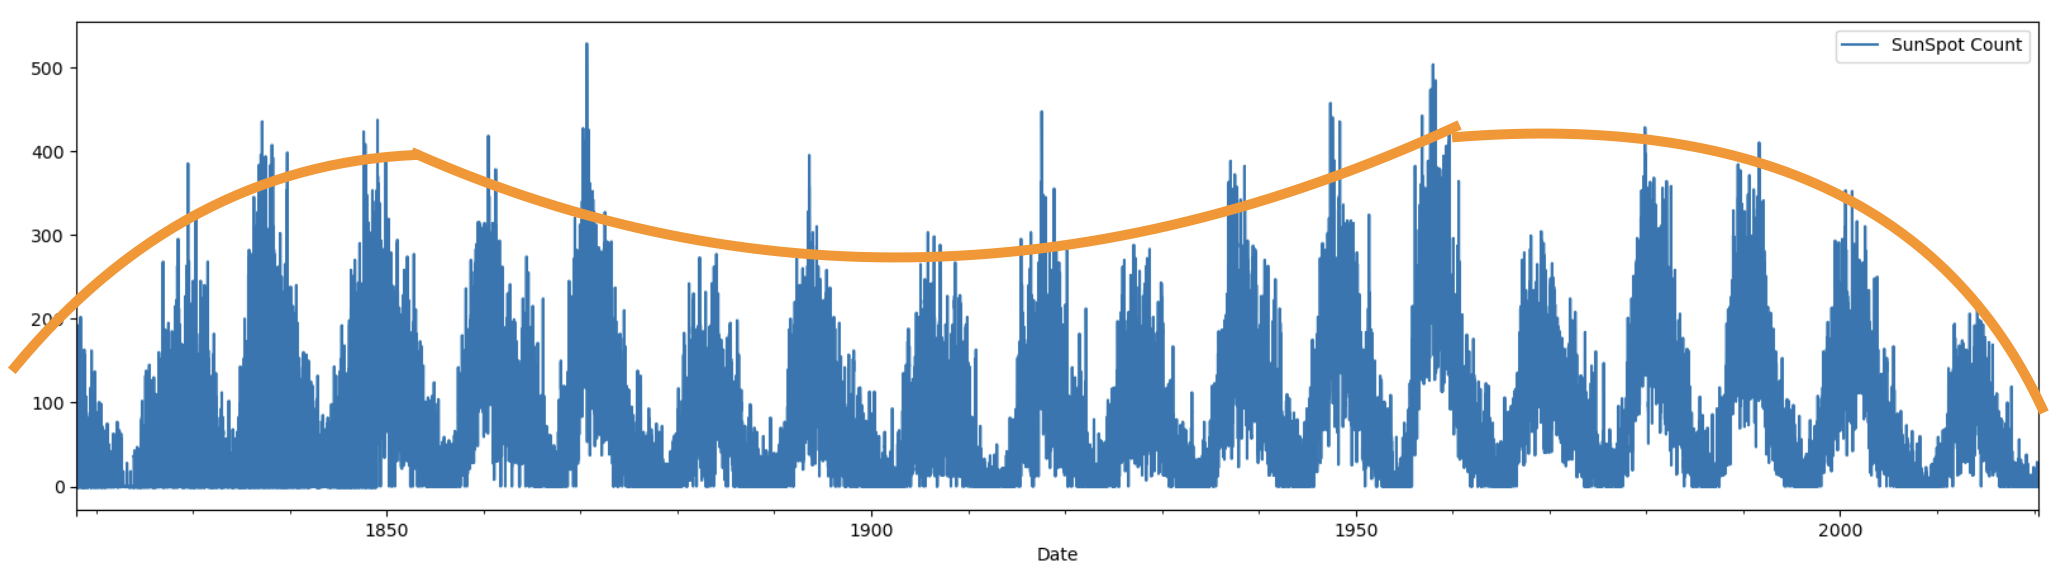

## Let's look at some models

### Option 1: Can something as simple as several moving averages explain the complexity?

In [7]:
window = 730 #makes for a two year rolling average
sun['2yr'] = sun.iloc[:,1].rolling(window=24).mean()
sun['20yr'] = sun.iloc[:,1].rolling(window=7300).mean()

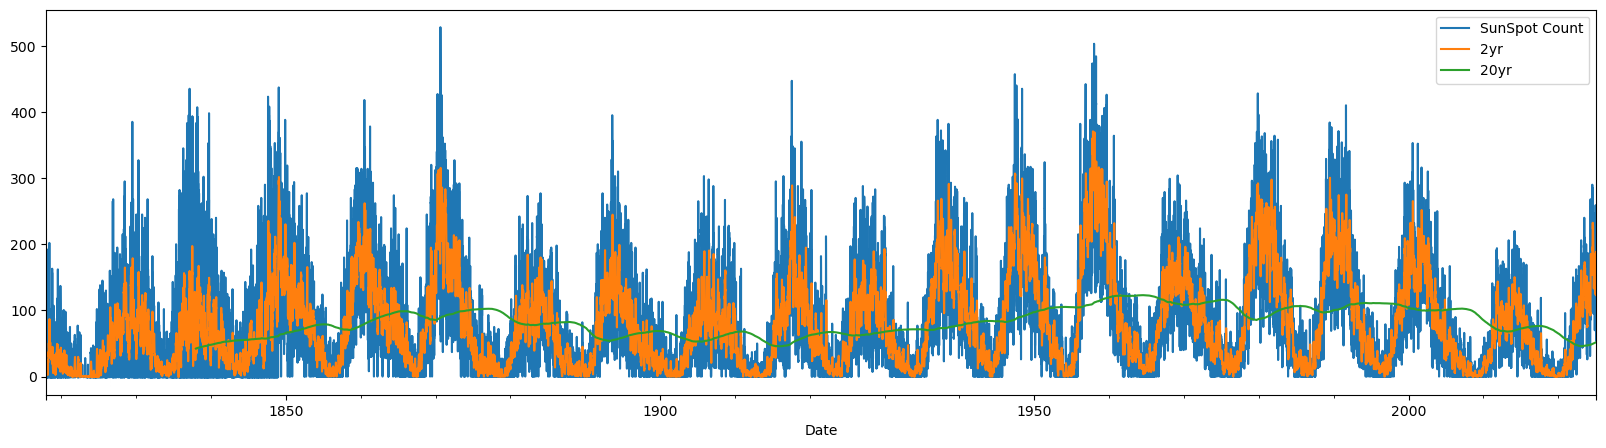

In [8]:
plt.figure(figsize = (20, 5))
ax = plt.gca()

sun.plot(kind='line', x='Date', y='SunSpot Count', ax=ax)
sun.plot(kind='line', x='Date', y='2yr', ax=ax)
sun.plot(kind='line', x='Date', y='20yr', ax=ax)
plt.show()

This isn't really displaying the way I would like it to. I'd like the moving average to have more amplitude in order to more closely follow the peaks. Unfortunately, an exponential moving average isn't that much better in this case.

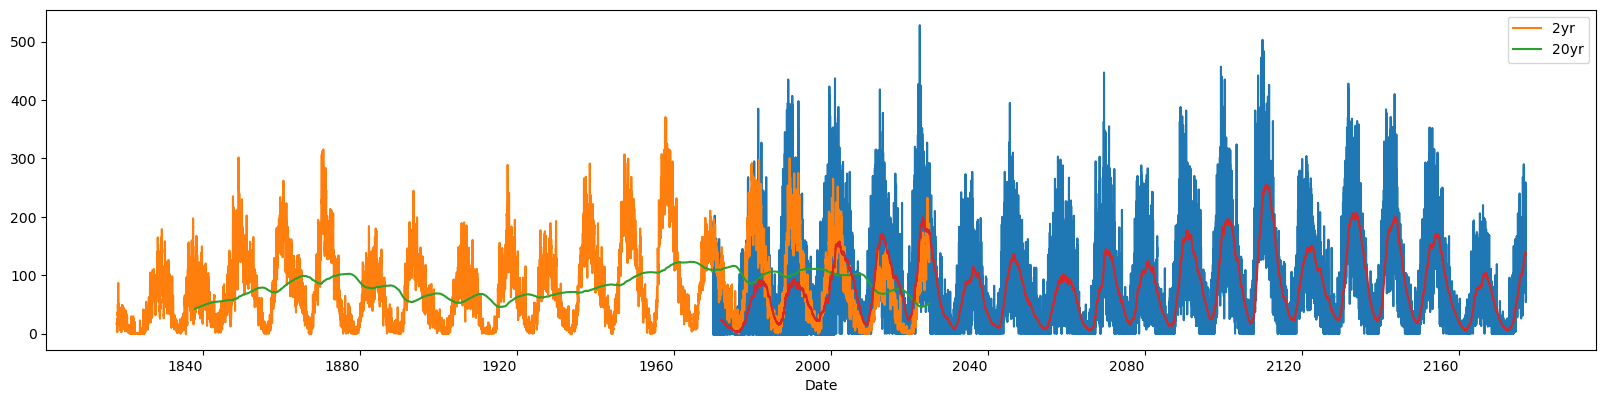

In [9]:
plt.figure(figsize = (20, 5))
ax = plt.gca()

sun['SunSpot Count'].plot()

sun.plot(kind='line', x='Date', y='2yr', ax=ax)
sun.plot(kind='line', x='Date', y='20yr', ax=ax)
sun['SunSpot Count'].ewm(span=720, adjust=False, min_periods=720).mean().plot()

#sun.plot(kind='line', x='Date', y='SunSpot Count', ax=ax)
plt.show()

This chart is very cool. It predicts out another 150 or so years.

It's also very flawed.

All this is doing is just shifting the observational data (in blue) to the right giving the appearance of prediction when it is, in fact, the basis of the moving averages in orange and green. The red is an exponential weighted moving average. What it should look like, but is still useless, is this:


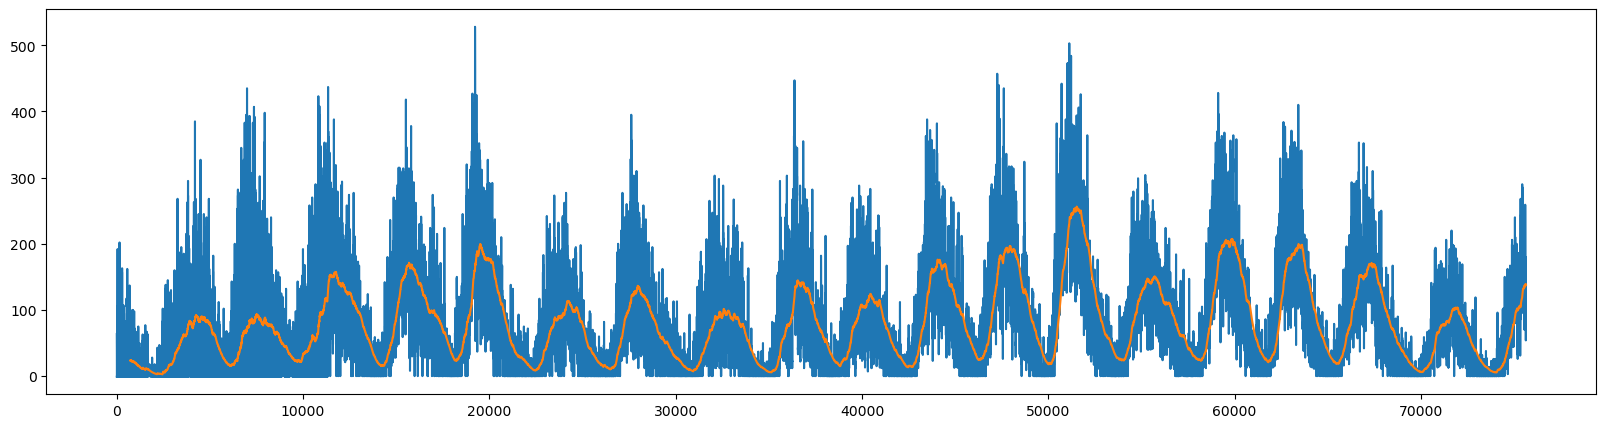

In [10]:
plt.figure(figsize = (20, 5))
ax = plt.gca()

sun['SunSpot Count'].plot()
sun['SunSpot Count'].ewm(span=720, adjust=False, min_periods=720).mean().plot()

plt.show()

My sense is that's due to the data being both daily and trying to cram so much into such a small section. If I subset a portion of the data, the exponential weighted average follows much more closely.

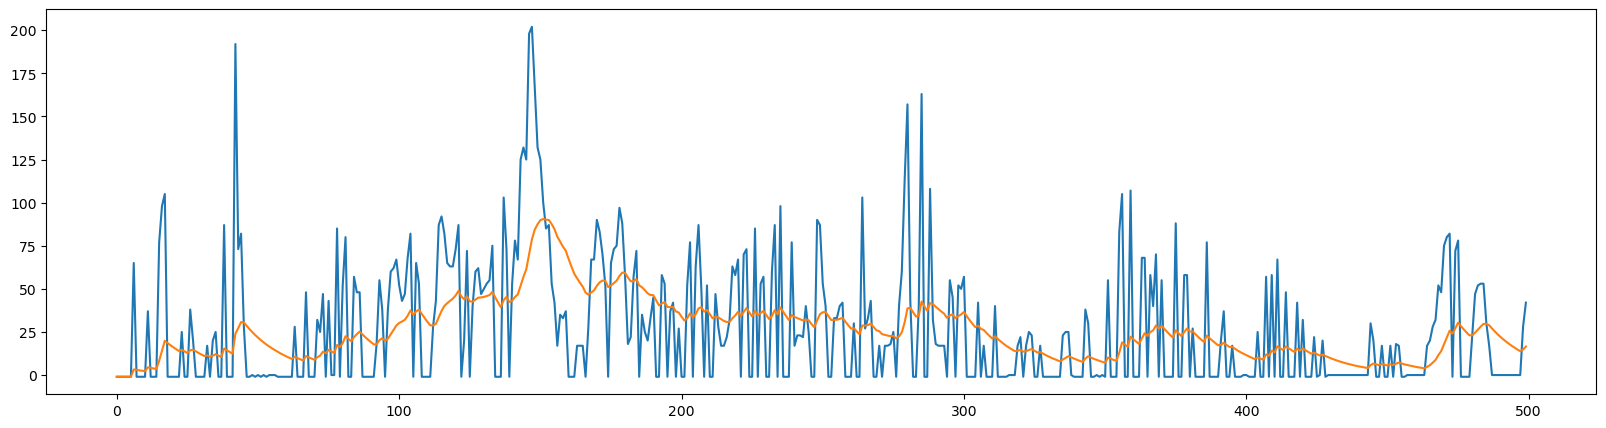

In [11]:
plt.figure(figsize = (20, 5))
ax = plt.gca()

sun['SunSpot Count'][:500].plot() # Checking for only first 200 data set
sun['SunSpot Count'][:500].ewm(span=30, adjust=False, min_periods=1).mean().plot(label='Exponential Smooting M A')
plt.show()

This is closer but let's also group the data by month.

### Option 2: What can ARMA do?



It's been a while so a refresher on how FFT works would be useful

So, starting with FFT

### Options 3: FFT is the choice for me!
(AKA, building toy models like one of Santa's insane elves)
Also, I hope you caught the [Letterkenny reference](https://www.youtube.com/watch?v=Wucj-cHGTw4&ab_channel=Crave)

#### 3.1 Make a sine wave generator graphically.

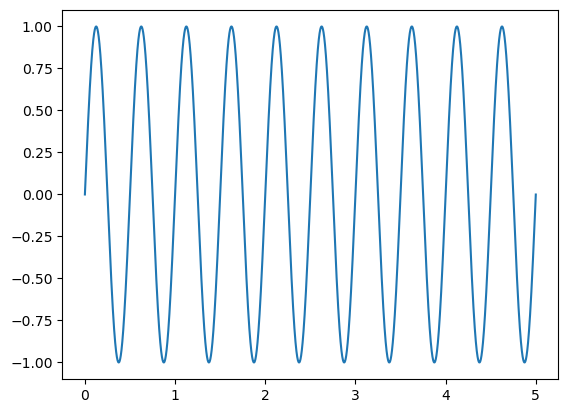

In [12]:
SAMPLE_RATE = 44100  # Hertz
DURATION = 5  # Seconds

def generate_sine_wave(freq, sample_rate, duration):
    x = np.linspace(0, duration, sample_rate * duration, endpoint=False)
    frequencies = x * freq
    # 2pi because np.sin takes radians
    y = np.sin((2 * np.pi) * frequencies)
    return x, y

# Number of samples in normalized_tone
N = SAMPLE_RATE * DURATION

# Generate a 2 hertz sine wave that lasts for 5 seconds
x, y = generate_sine_wave(2, SAMPLE_RATE, DURATION)
plt.plot(x, y)
plt.show()

#### 3.2 Use the sine wave generator to make a superposition to two tones.

In [13]:
_, nice_tone = generate_sine_wave(400, SAMPLE_RATE, DURATION)
_, noise_tone = generate_sine_wave(4000, SAMPLE_RATE, DURATION)
noise_tone = noise_tone * 0.3

mixed_tone = nice_tone + noise_tone

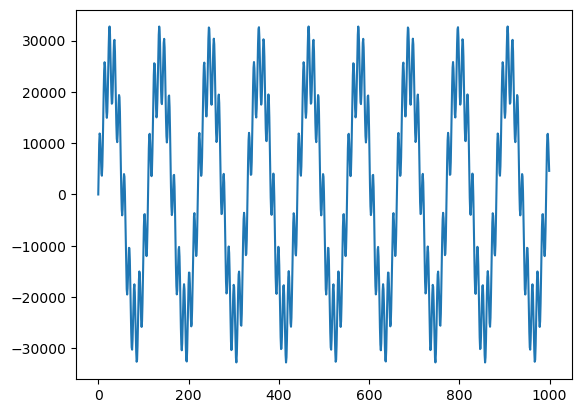

In [14]:
normalized_tone = np.int16((mixed_tone / mixed_tone.max()) * 32767)

plt.plot(normalized_tone[:1000])
plt.show()

In [15]:
# Remember SAMPLE_RATE = 44100 Hz is our playback rate
write("mysinewave.wav", SAMPLE_RATE, normalized_tone)

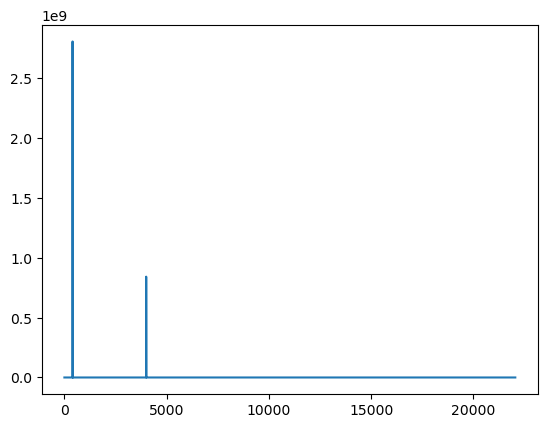

In [16]:
# Note the extra 'r' at the front
yf = rfft(normalized_tone)
xf = rfftfreq(N, 1 / SAMPLE_RATE)

plt.plot(xf, np.abs(yf))

plt.show()

This is what we'd expect with the approximate location of the frequency spikes.


In [17]:
print(yf, len(yf))

[ 1.          0.50423852  0.86356443 ...  0.50423851 -0.86356443
  1.        ] 220500


In [18]:
print(xf, len(xf))

[0.00000e+00 2.00000e-01 2.00000e-01 ... 2.20498e+04 2.20498e+04
 2.20500e+04] 220500


In [19]:
max(xf)

np.float64(22050.0)

#### 3.3 Nice but I really want those spikes labeled with their frequencies

In [20]:
yf.size

220500

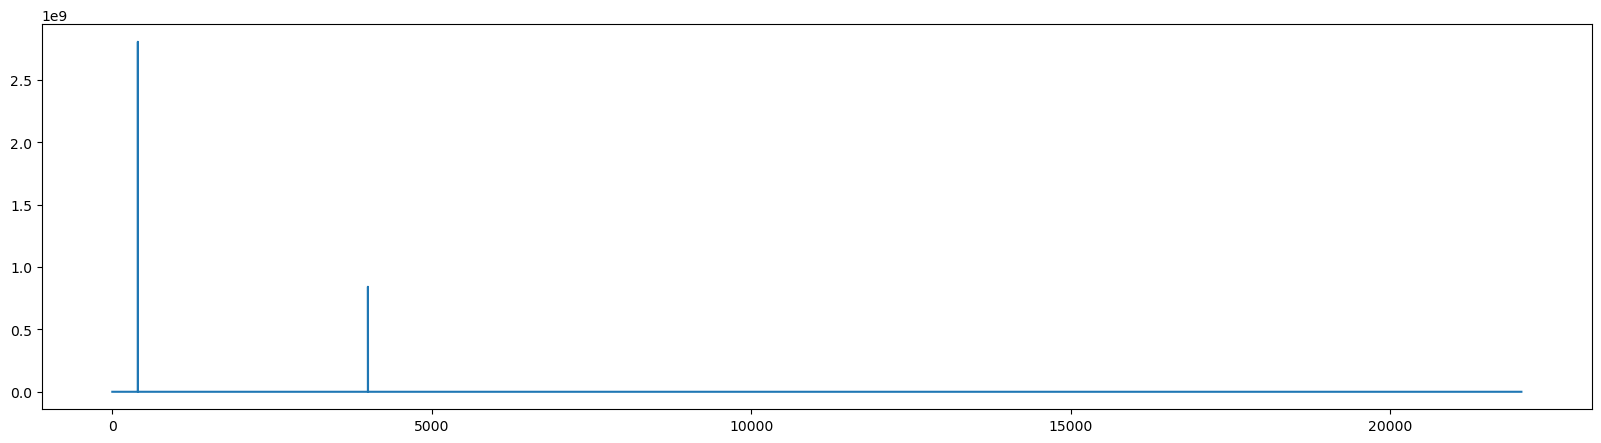

In [21]:
# Note the extra 'r' at the front
plt.figure(figsize = (20, 5))

yf = rfft(normalized_tone)
xf = rfftfreq(N, 1 / SAMPLE_RATE)
peaks, _ = find_peaks(x, distance=10)
plt.plot(xf, np.abs(yf))

plt.show()

#### 3.4 Let's take a step back and use find_peaks to see if I can get that to label the values.
I'm using the find_peaks and using the electrocardiogram dataset 

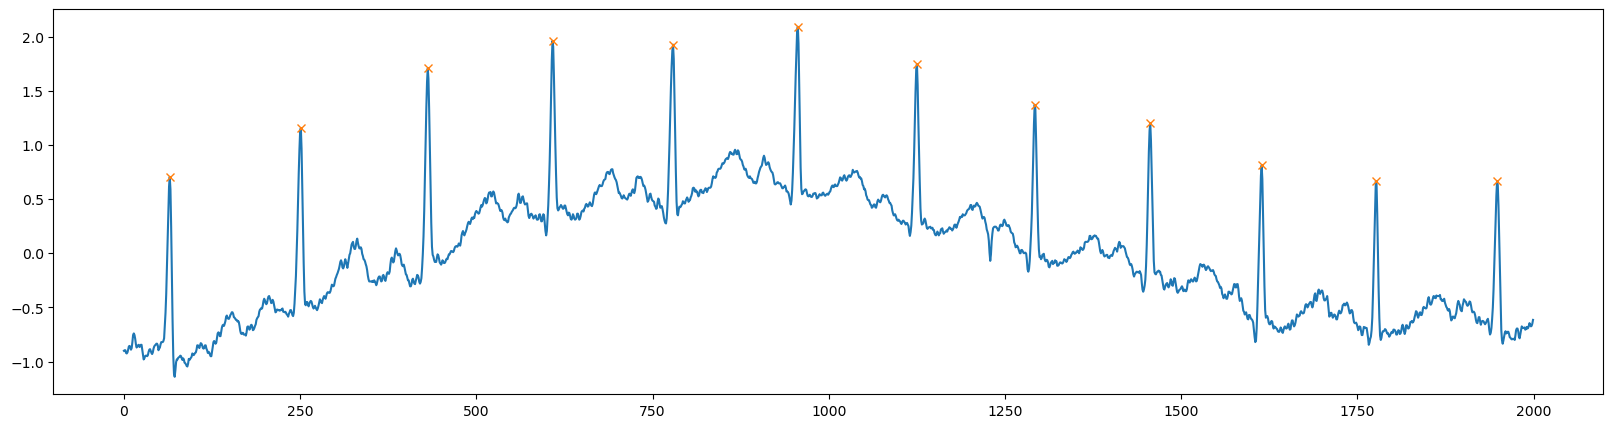

array([186, 180, 177, 171, 177, 169, 167, 164, 158, 162, 172])

In [22]:
plt.figure(figsize = (20, 5))

x = electrocardiogram()[2000:4000]

peaks, _ = find_peaks(x, distance=150)

c= np.diff(peaks)

plt.plot(x)
plt.plot(peaks, x[peaks], 'x')
plt.show()
c

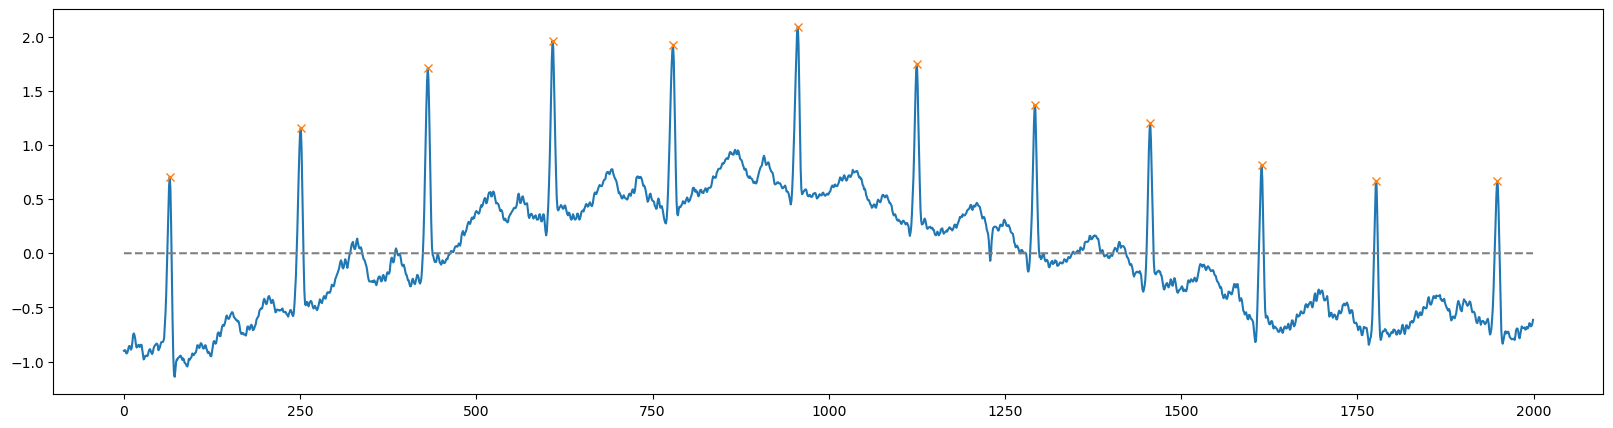

In [23]:
plt.figure(figsize = (20, 5))
x = electrocardiogram()[2000:4000]
peaks, _ = find_peaks(x, height=0, distance=100)
plt.plot(x)
plt.plot(peaks, x[peaks], "x")
plt.plot(np.zeros_like(x), "--", color="gray")
plt.show()

In [24]:
p, q = peaks, x[peaks]

peaks, _ = find_peaks(x, distance=150)
np.diff(peaks)

array([186, 180, 177, 171, 177, 169, 167, 164, 158, 162, 172])

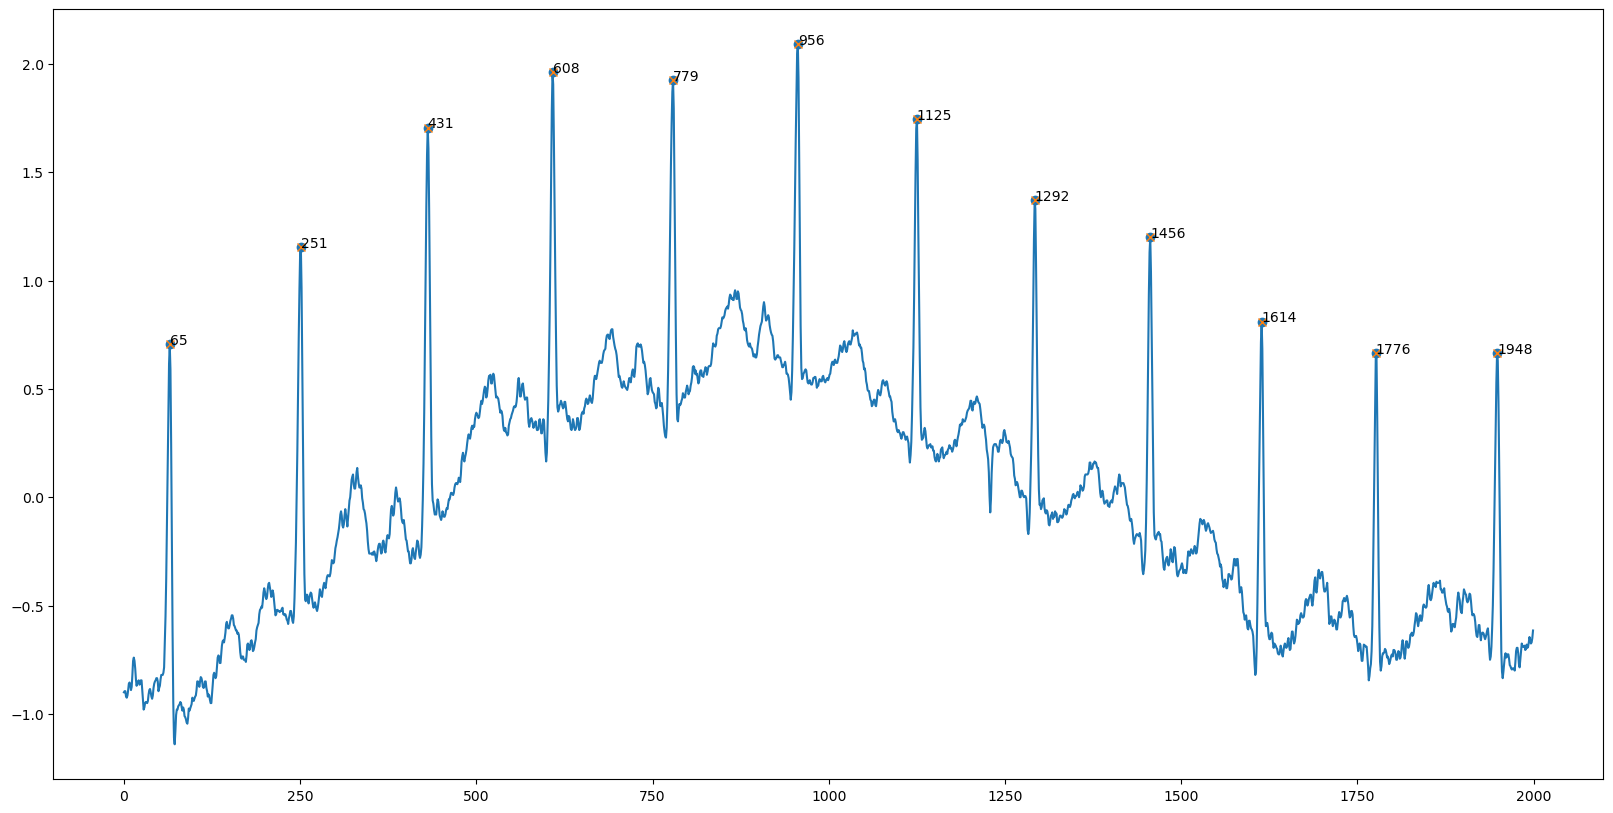

In [25]:
fig, ax = plt.subplots()
ax.scatter(p, q)
plt.gcf().set_size_inches(20, 10)
for i, txt in enumerate(p):
    ax.annotate(txt, (p[i], q[i]))

plt.plot(x)
plt.plot(peaks, x[peaks], 'x')

plt.show()

In [26]:
fft = np.fft.fft(sun['SunSpot Count'])

for i in range(2):
    print("Value at index {}:\t{}".format(i, fft[i + 1]), "\nValue at index {}:\t{}".format(fft.size -1 - i, fft[-1 - i]))

Value at index 0:	(-263179.3208050662+613599.8641847274j) 
Value at index 75635:	(-263179.32080506615-613599.8641847272j)
Value at index 1:	(-846426.1901503494-363181.9008676632j) 
Value at index 75634:	(-846426.1901503495+363181.90086766286j)


#### As a recap --

 1. We made a normalized tone `cell 16` as toy model 
 2. We got a rough visual model of the frequencies using FFT `cell 17`
 3. We found we could the x values of peaks using scikit-learn's `find_peaks`

So now we're going to do it all again. Generate the tone, run an FFT on the resulting compound waveform, and get the x values of the FFT peaks which we expect to be the the values we put into the tone generator.

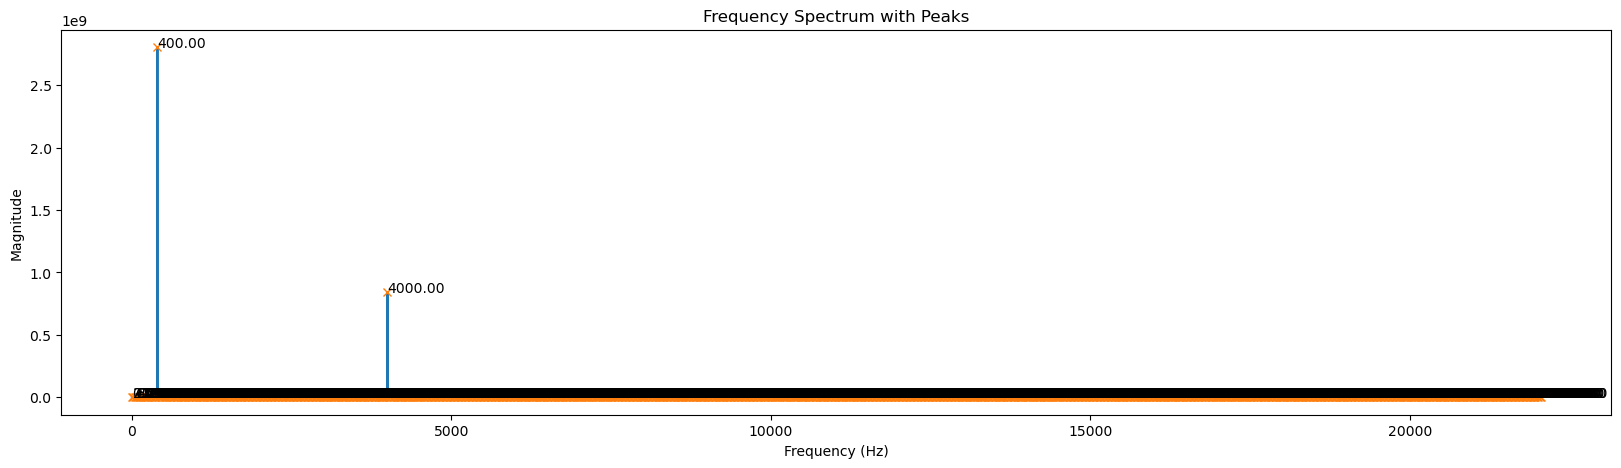

In [27]:
def generate_sine_wave(freq, sample_rate, duration):
    x = np.linspace(0, duration, sample_rate * duration, endpoint=False)
    frequencies = x * freq
    y = np.sin((2 * np.pi) * frequencies)
    return x, y

# Superposition of two tones
_, nice_tone = generate_sine_wave(400, SAMPLE_RATE, DURATION)
_, noise_tone = generate_sine_wave(4000, SAMPLE_RATE, DURATION)
noise_tone = noise_tone * 0.3
mixed_tone = nice_tone + noise_tone

# Normalize the mixed tone
normalized_tone = np.int16((mixed_tone / mixed_tone.max()) * 32767)

# Perform FFT
N = SAMPLE_RATE * DURATION
yf = rfft(normalized_tone)
xf = rfftfreq(N, 1 / SAMPLE_RATE)

# Find peaks in the frequency domain
peaks, _ = find_peaks(np.abs(yf), distance=150)

# Plotting
plt.figure(figsize=(20, 5))
plt.plot(xf, np.abs(yf))
plt.plot(xf[peaks], np.abs(yf)[peaks], 'x')

# Annotate the peaks with their values
for peak in peaks:
    plt.annotate(f'{xf[peak]:.2f}', xy=(xf[peak], np.abs(yf)[peak]), xytext=(xf[peak], np.abs(yf)[peak] + 500))

plt.xlabel('Frequency (Hz)')
plt.ylabel('Magnitude')
plt.title('Frequency Spectrum with Peaks')
plt.show()

### Option 4: Use Statsmodels seasonal_decompose

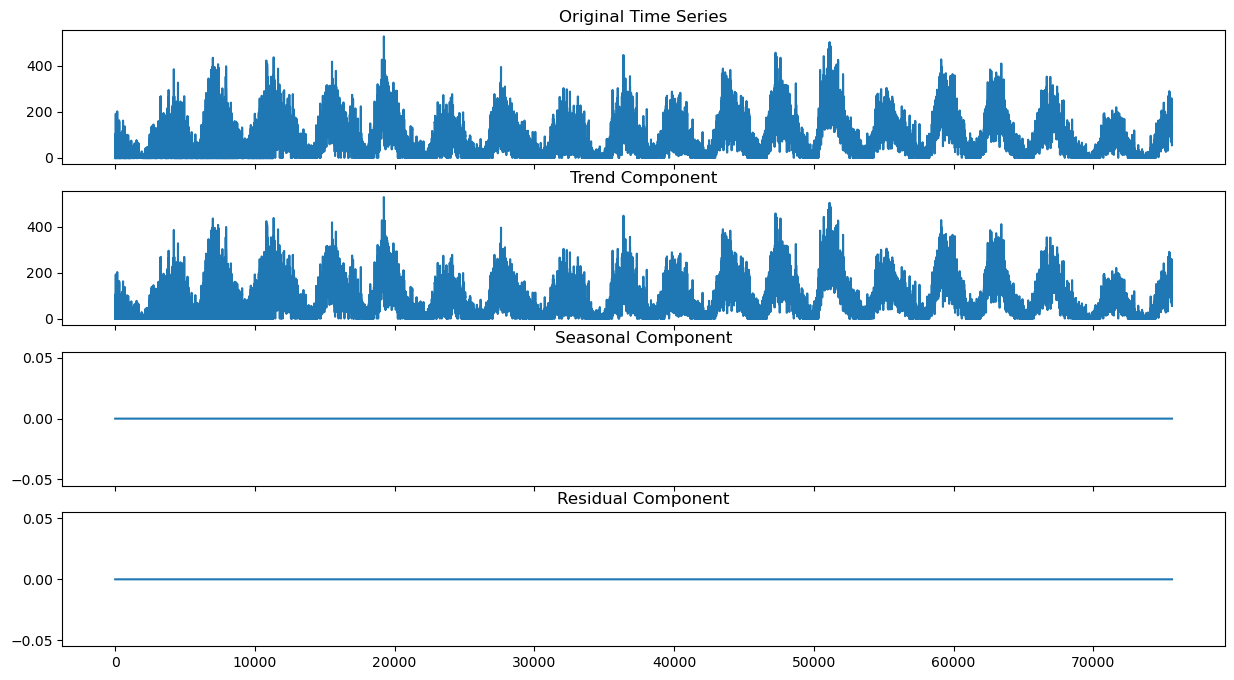

In [28]:
from statsmodels.tsa.seasonal import seasonal_decompose

# Load the sunspot data into a pandas DataFrame
sun
# Decompose the time series into its trend, seasonal, and residual components
decomposition = seasonal_decompose(sun['SunSpot Count'], model='additive', period=1)

# Plot the original time series and its components
fig, ax = plt.subplots(nrows=4, sharex=True, figsize=(15, 8))
ax[0].plot(sun['SunSpot Count'])
ax[0].set(title='Original Time Series')
ax[1].plot(decomposition.trend)
ax[1].set(title='Trend Component')
ax[2].plot(decomposition.seasonal)
ax[2].set(title='Seasonal Component')
ax[3].plot(decomposition.resid)
ax[3].set(title='Residual Component')
plt.show()


#### Whenever I see something this 'good' I get suspicious.
Let's change the period.

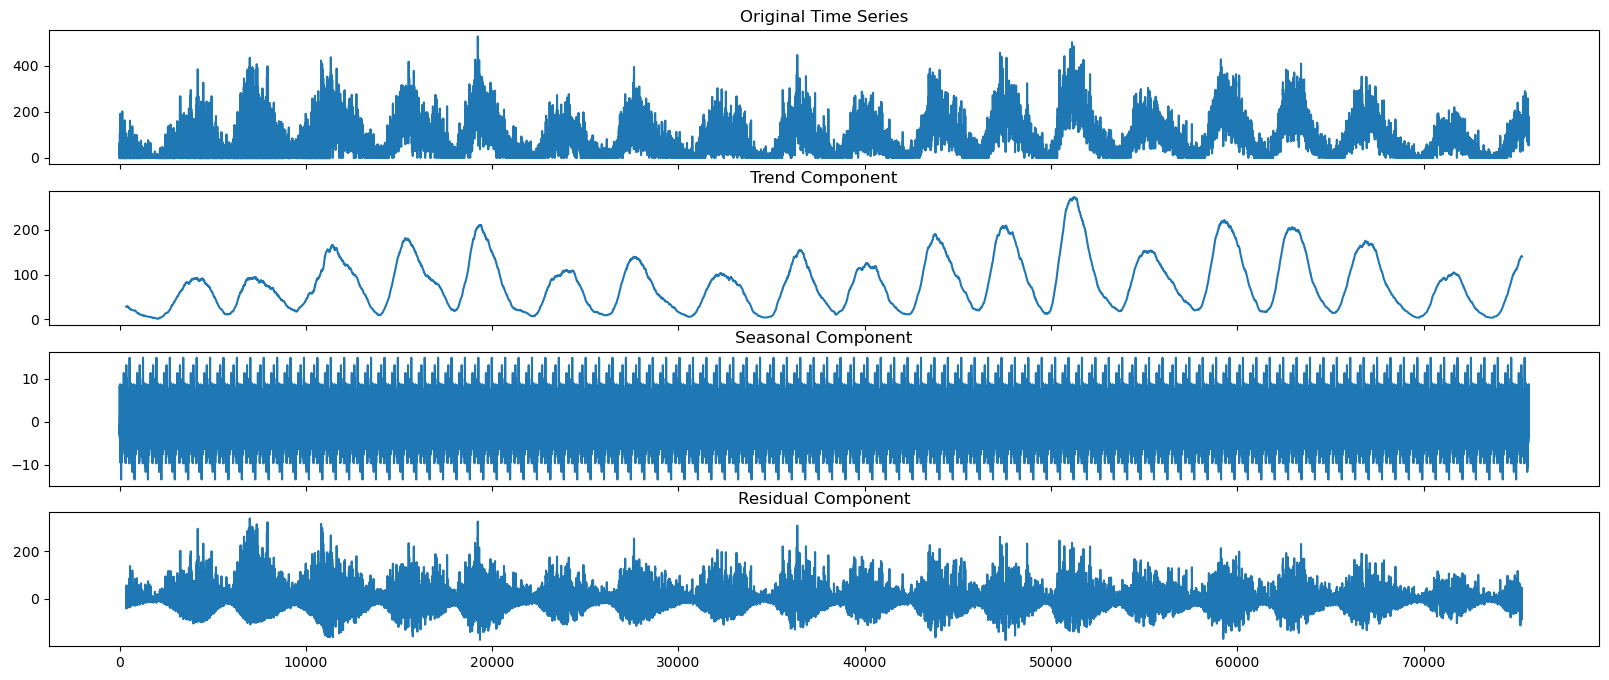

In [29]:
# Load the sunspot data into a pandas DataFrame
sun
# Decompose the time series into its trend, seasonal, and residual components
decomposition = seasonal_decompose(sun['SunSpot Count'], model='additive', period=720)

# Plot the original time series and its components
fig, ax = plt.subplots(nrows=4, sharex=True, figsize=(20, 8))
ax[0].plot(sun['SunSpot Count'])
ax[0].set(title='Original Time Series')
ax[1].plot(decomposition.trend)
ax[1].set(title='Trend Component')
ax[2].plot(decomposition.seasonal)
ax[2].set(title='Seasonal Component')
ax[3].plot(decomposition.resid)
ax[3].set(title='Residual Component')
plt.show()

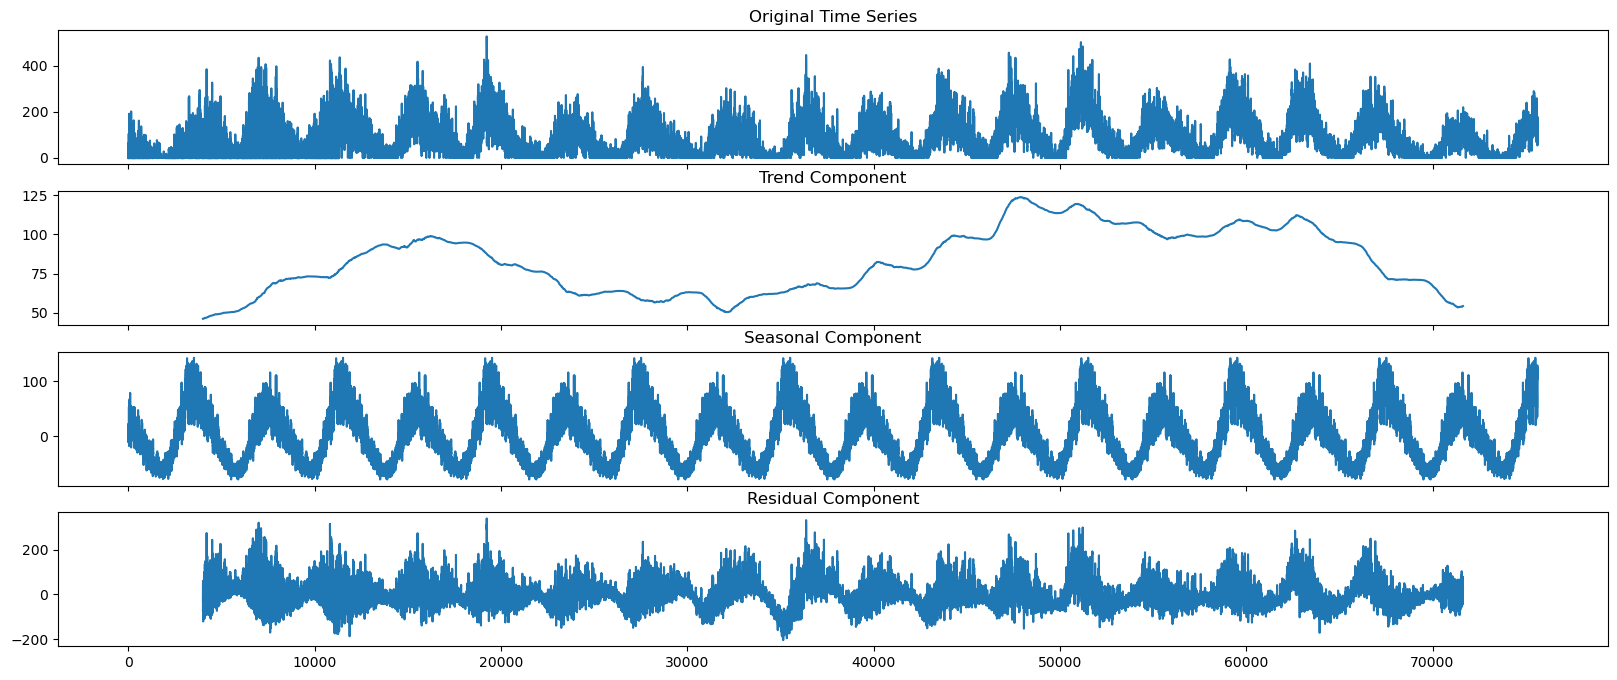

In [30]:
# Load the sunspot data into a pandas DataFrame
sun
# Decompose the time series into its trend, seasonal, and residual components
decomposition = seasonal_decompose(sun['SunSpot Count'], model='additive', period=8000)

# Plot the original time series and its components
fig, ax = plt.subplots(nrows=4, sharex=True, figsize=(20, 8))
ax[0].plot(sun['SunSpot Count'])
ax[0].set(title='Original Time Series')
ax[1].plot(decomposition.trend)
ax[1].set(title='Trend Component')
ax[2].plot(decomposition.seasonal)
ax[2].set(title='Seasonal Component')
ax[3].plot(decomposition.resid)
ax[3].set(title='Residual Component')
plt.show()

### Alright STOP, collaborate and listen.

#### I'm presuming you followed along with a just a bit of attention. Did you catch the error? Or, maybe better yet, what do you think the errors are up to this point? What I have is below but you need to highlight it to see it.¶

Also, I want to apologize for working in the Vanilla Ice lyrics. 


<style>backgroundColor = 'black'
<span style="color:blue">
To my mind there is no science here, just as I mentioned at the top. This has been using a few of tools of Data Science but that not the same as doing science. There isn't a rigorous evaluation of the results, just pretty pictures. And I think this is one of the dangers of Data Science. Often it's little more than Data Analysis or even just Story Time with Data.

Furthermore, the lack of reproducibility and validation in many data science projects can lead to misleading conclusions. Without proper methodologies, the insights drawn may not hold up under scrutiny or /'real-world application. It's essential to differentiate between superficial data exploration and thorough scientific inquiry.

Another point to consider is the ethical implications of presenting data without adequate context. Data can be manipulated to support various narratives, and without a critical approach, we risk spreading misinformation or bias. Decision-makers must also maintain a critical eye and be vigilant against potential spin in the presentation of data.

Now, with that in mind, am I going to continue on with this? No. I've made the point I wanted to. Hopefully, that illustrates the role and responsibility of the Data Scientist -- but also whoever receives it. The goal should always be to strive for accuracy, transparency, and rigor in our analysis. Ultimately, it's about making informed decisions based on solid evidence, rather than just crafting a compelling story.

</span>
</style>

As I mentioned at the top, there is no science here. This has instead been using a few of tools and some of the techniques of Data Science but that is not the same as doing science. There isn't a rigorous evaluation of the results, just pretty pictures. And I think this is one of the dangers of Data Science. Often it's little more than Data Analysis or even just Story Time with Data.
</br></br>
Furthermore, the lack of reproducibility and validation in many data science projects can lead to misleading conclusions. Without proper methodologies, the insights drawn may not hold up under scrutiny or /'real-world application. It's essential to differentiate between superficial data exploration and thorough scientific inquiry.
</br></br>
Another point to consider is the ethical implications of presenting data without adequate context. Data can be manipulated to support various narratives, and without a critical approach, we risk spreading misinformation or bias. Decision-makers must also maintain a critical eye and be vigilant against potential spin in the presentation of data.
</br></br>
Now, with that in mind, am I going to continue on with this? No. I've made the point I wanted to. Hopefully, that illustrates the role and responsibility of the Data Scientist -- but also whoever receives it. The goal should always be to strive for accuracy, transparency, and rigor in our analysis. Ultimately, it's about making informed decisions based on solid evidence, rather than just crafting a compelling story.

# But ...

OK, point made. But what if you *couldn't* let it go? What then? 

Then you'd need a drastically different approach. One that is based on what we've learned from experience. 

1. It has to be testable but we only have one spin at the wheel unless we want to wait a few more centuries. So need to split the data and keep some in reserve.

2. We need to be inquisitive but critical of the answers we get.


In [31]:
stellar = sun.copy()
# using about 30% for the testing data and the rest for the working data
len(stellar)*.7 

52945.2

In [32]:
stellar_working = stellar[:53000]
len(stellar_working), stellar_working

(53000,
             Date  SunSpot Count  DailyStDev  Observations  Indicator  \
 0     1818-01-02             -1        -1.0             0       True   
 1     1818-01-03             -1        -1.0             0       True   
 2     1818-01-04             -1        -1.0             0       True   
 3     1818-01-05             -1        -1.0             0       True   
 4     1818-01-06             -1        -1.0             0       True   
 ...          ...            ...         ...           ...        ...   
 52995 1963-02-06             71         5.6             1       True   
 52996 1963-02-07             68         5.5             1       True   
 52997 1963-02-08             57         5.0             1       True   
 52998 1963-02-09             45         4.5             1       True   
 52999 1963-02-10             31         3.8             1       True   
 
        Fractional Date        2yr        20yr  
 0             1818.004        NaN         NaN  
 1             1

In [33]:
stellar_testing = stellar[53000:]
len(stellar_testing), stellar_testing

(22636,
             Date  SunSpot Count  DailyStDev  Observations  Indicator  \
 53000 1963-02-11             26         3.5             1       True   
 53001 1963-02-12             24         3.3             1       True   
 53002 1963-02-13             14         2.5             1       True   
 53003 1963-02-14             24         3.3             1       True   
 53004 1963-02-15             25         3.4             1       True   
 ...          ...            ...         ...           ...        ...   
 75631 2025-01-27             54        12.6            29      False   
 75632 2025-01-28             75        11.8            19      False   
 75633 2025-01-29             82        10.4            28      False   
 75634 2025-01-30            106        21.0            29      False   
 75635 2025-01-31            146        32.1            23      False   
 
        Fractional Date         2yr        20yr  
 53000         1963.114   38.166667  122.120274  
 53001        

In [34]:
stellar_working = stellar_working.sort_values('Date')

# Resample to get monthly, trimonthly, and half-yearly data
monthly_stellar_working = stellar_working.resample('MS').mean()
trimonthly_stellar_working = stellar_working.resample('3MS').mean()
halfyearly_stellar_working = stellar_working.resample('6MS').mean()
yearly_stellar_working = stellar_working.resample('12MS').mean()

# Plot the original daily data
plt.figure(figsize=(20, 5))
ax = plt.gca()
stellar_working.plot(kind='line', y='SunSpot Count', ax=ax)
plt.title('Daily SunSpot Count')
plt.show()

# Plot the monthly data
plt.figure(figsize=(20, 5))
ax = plt.gca()
monthly_stellar_working.plot(kind='line', y='SunSpot Count', ax=ax)
plt.title('Monthly SunSpot Count')
plt.show()

# Plot the trimonthly data
plt.figure(figsize=(20, 5))
ax = plt.gca()
trimonthly_stellar_working.plot(kind='line', y='SunSpot Count', ax=ax)
plt.title('Trimonthly SunSpot Count')
plt.show()

# Plot the half-yearly data
plt.figure(figsize=(20, 5))
ax = plt.gca()
halfyearly_stellar_working.plot(kind='line', y='SunSpot Count', ax=ax)
plt.title('Half-Yearly SunSpot Count')
plt.show()

# Plot the yearly data
plt.figure(figsize=(20, 5))
ax = plt.gca()
yearly_stellar_working.plot(kind='line', y='SunSpot Count', ax=ax)
plt.title('Yearly SunSpot Count')
plt.show()

# Function to plot FFT and find peaks
def plot_fft(data, sample_rate, title, time_unit='days'):
    # Compute FFT
    N = len(data)
    yf = rfft(data)
    xf = rfftfreq(N, 1 / sample_rate)

    # Find peaks
    peaks, _ = find_peaks(np.abs(yf), distance=10)

    # Plotting
    plt.figure(figsize=(20, 5))
    plt.plot(xf, np.abs(yf))
    plt.plot(xf[peaks], np.abs(yf)[peaks], 'x')
    plt.xlabel(f'Frequency (cycles per {time_unit})')
    plt.ylabel('Magnitude')
    plt.title(title)

    # Annotate the peaks with their values
    for peak in peaks:
        plt.annotate(f'{xf[peak]:.6f}', xy=(xf[peak], np.abs(yf)[peak]), xytext=(xf[peak], np.abs(yf)[peak] + 500))
    plt.show()

TypeError: Only valid with DatetimeIndex, TimedeltaIndex or PeriodIndex, but got an instance of 'RangeIndex'

/var/folders/_3/9_qsgmm55yg0k3k8tgh0gy3w0000gn/T/ipykernel_57956/2703571618.py:10: RuntimeWarning: divide by zero encountered in divide
  years_per_cycle = 1 / (xf * 365)


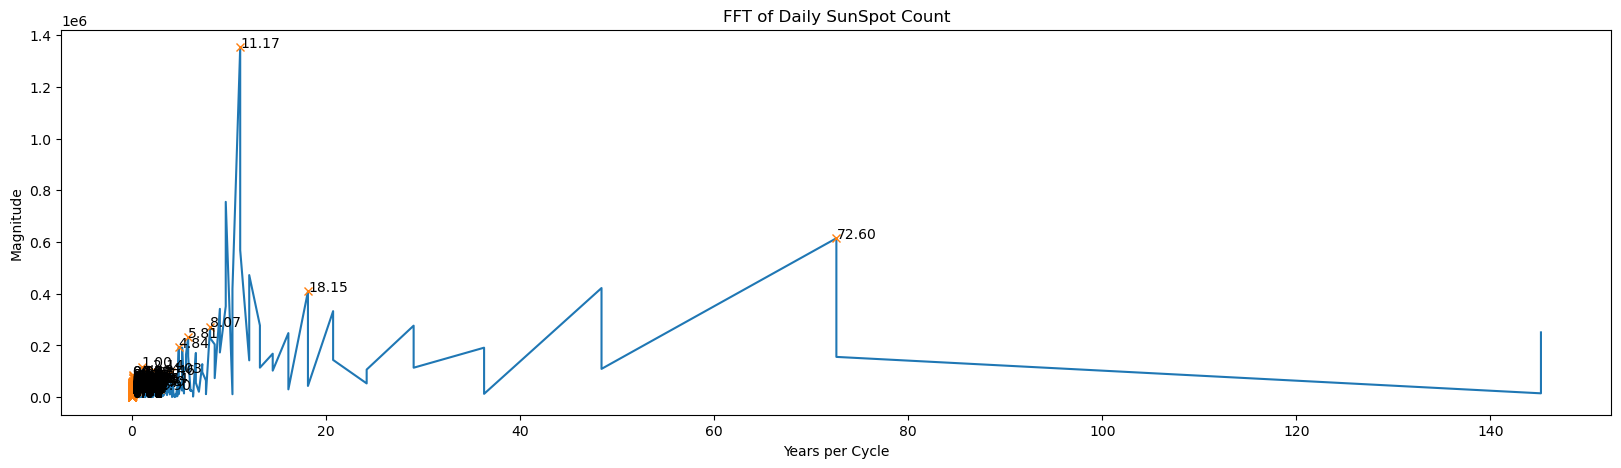

NameError: name 'monthly_stellar_working' is not defined

In [39]:
# Function to plot FFT and find peaks with x-axis as years per cycle
def plot_fft(data, sample_rate, title, time_unit='days'):
    # Compute FFT
    N = len(data)
    yf = rfft(data)
    xf = rfftfreq(N, 1 / sample_rate)

    # Convert frequency to years per cycle
    if time_unit == 'days':
        years_per_cycle = 1 / (xf * 365)
    elif time_unit == 'months':
        years_per_cycle = 1 / (xf * 12)
    elif time_unit == 'years':
        years_per_cycle = 1 / xf

    # Find peaks
    peaks, _ = find_peaks(np.abs(yf), distance=10)

    # Plotting
    plt.figure(figsize=(20, 5))
    plt.plot(years_per_cycle, np.abs(yf))
    plt.plot(years_per_cycle[peaks], np.abs(yf)[peaks], 'x')
    plt.xlabel('Years per Cycle')
    plt.ylabel('Magnitude')
    plt.title(title)

    # Annotate the peaks with their values
    for peak in peaks:
        plt.annotate(f'{years_per_cycle[peak]:.2f}', xy=(years_per_cycle[peak], np.abs(yf)[peak]), xytext=(years_per_cycle[peak], np.abs(yf)[peak] + 500))
    plt.show()

# Daily data
plot_fft(stellar_working['SunSpot Count'].values, sample_rate=1, title='FFT of Daily SunSpot Count', time_unit='days')

# Monthly data
plot_fft(monthly_stellar_working['SunSpot Count'].values, sample_rate=1/30, title='FFT of Monthly SunSpot Count', time_unit='months')

# Yearly data
plot_fft(halfyearly_stellar_working['SunSpot Count'].values, sample_rate=1/(12*30), title='FFT of Half-Yearly SunSpot Count', time_unit='months')


Back to the critical thinking part. Doesn't it seem strange that the graphs are all the same? But numbers vary? So, for example, on the top graph, the is a value of 72.60 but it's 32177.50 in the middle and 4365 on the bottom. But notice also the x-axis also scales accordingly. 

were going to take the top 5 highest points on the top. That looks like:

11.17, 72.60, 18.15, 8.07, 5.81

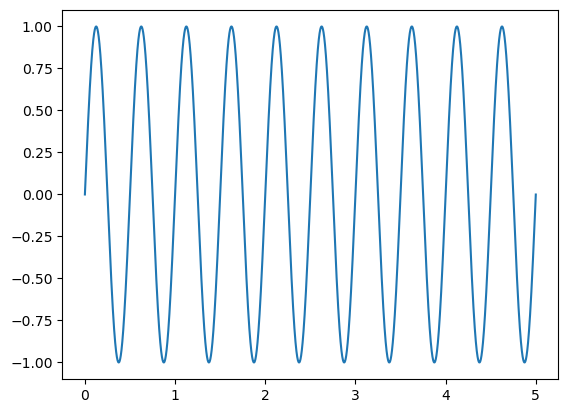

In [37]:
SAMPLE_RATE = 44100  # Hertz
DURATION = 5  # Seconds

def generate_sine_wave(freq, sample_rate, duration):
    x = np.linspace(0, duration, sample_rate * duration, endpoint=False)
    frequencies = x * freq
    # 2pi because np.sin takes radians
    y = np.sin((2 * np.pi) * frequencies)
    return x, y

# Number of samples in normalized_tone
N = SAMPLE_RATE * DURATION

# Generate a 2 hertz sine wave that lasts for 5 seconds
x, y = generate_sine_wave(2, SAMPLE_RATE, DURATION)
plt.plot(x, y)
plt.show()

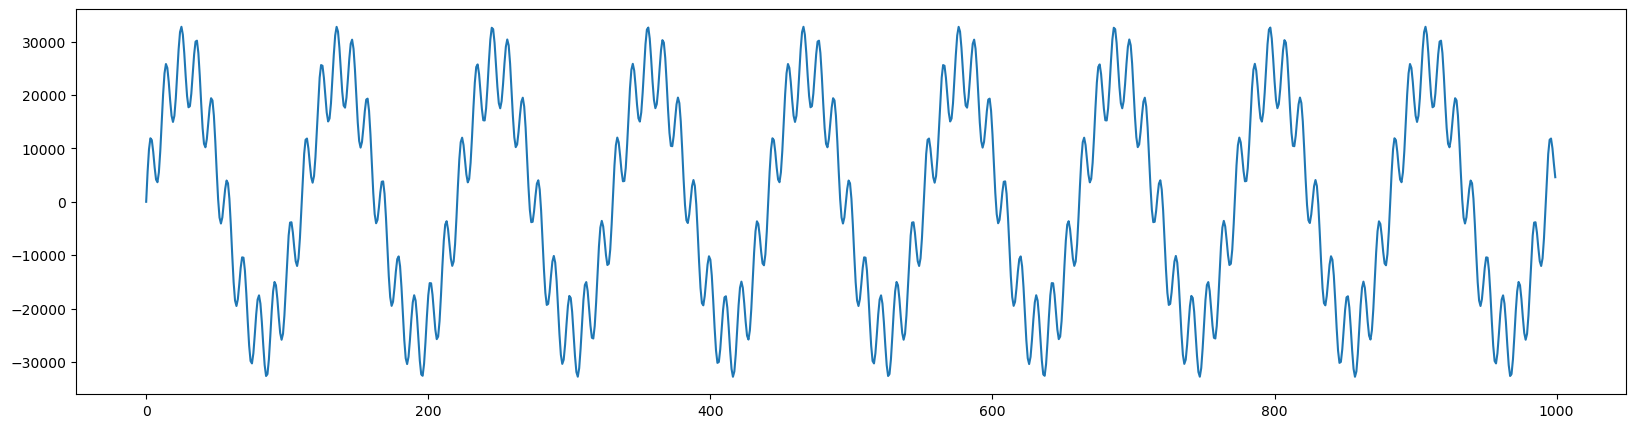

In [38]:
_, first_wave = generate_sine_wave(11.17, SAMPLE_RATE, DURATION)
_, first_wave = generate_sine_wave(72.6, SAMPLE_RATE, DURATION)
_, third_wave = generate_sine_wave(18.15, SAMPLE_RATE, DURATION)
_, fourth_wave = generate_sine_wave(8.07, SAMPLE_RATE, DURATION)
_, fifth_wave = generate_sine_wave(5.81, SAMPLE_RATE, DURATION)
# noise_tone = noise_tone * 0.3

mixed_wave = first_wave + first_wave + third_wave + fourth_wave + fifth_wave

normalized_wave = np.int16((mixed_wave / mixed_wave.max()) * 32767)

plt.figure(figsize=(20, 5))
plt.plot(normalized_tone[:1000])
plt.show()